# Basic python imports and model settings

In [ ]:
import underworld.visualisation as vis

from underworld import function as fn
import underworld as uw

import matplotlib.pyplot as pyplot
import numpy as np
from scipy.spatial import distance

import math
import os

import time as ti

from scipy.signal import savgol_filter

# details of the bottom curve
# details of the bottom curve
L = [160, 80, 40, 20, 10, 5]
i = 5

maxX = L[i] * 1000.
min_bed_height = 0.           # we want exactly 0 m of rock beneath the ice

maxY = 1000.

omega = 2. * np.pi / maxX
alpha = 0.1 / 360. * np.pi

beta_square = 1000. + 1000. * fn.math.sin(omega * fn.input()[0]) + 1e-18
As = 1. / beta_square
tau_b = maxY * np.sin(alpha) * 9.81 * 910.

g = 9.81
ice_density = 910.

A = 1e-16
n = 3.

resY = 100
resX = 250

print("resX: " + str(resX) + " resY: " + str(resY))

# generate output path
outputPath = os.path.join(os.path.abspath("."), "output_" + str(maxX) + "/")
if not os.path.exists(outputPath):
    os.makedirs(outputPath)

os.chdir(outputPath)
    
delta_timestep = 1.						# in years, used in the main loop
# after how many timesteps do we need new figures?
update_figures_after_n_timesteps = 1
number_of_deformation_lines = 11

number_of_deformation_points = 50000
distance_between_deformation_lines = maxY / (number_of_deformation_lines + 1)#

cell_height = maxY / (resY + 1)
cell_width = maxX / (resX + 1)

# Mesh + mesh variables

In [ ]:
elementType = "Q1/dQ0"

mesh = uw.mesh.FeMesh_Cartesian(elementType=(elementType),
                                elementRes=(resX, resY),
                                minCoord=(0., 0.),
                                maxCoord=(maxX, maxY),
                                periodic=[True, False])

submesh = mesh.subMesh

# save the mesh
# mesh.save(outputPath + "mesh.h5")

velocityField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=mesh.dim)
pressureField = uw.mesh.MeshVariable(mesh=mesh.subMesh, nodeDofCount=1)

viscosityField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=1)

materialField = uw.mesh.MeshVariable(mesh=mesh, nodeDofCount=1)

strainRateField = mesh.add_variable(1)
basalVelocityField = mesh.add_variable(1)

pressureField.data[:] = 0.
velocityField.data[:] = [0., 0.]
materialField.data[:] = [0]
basalVelocityField.data[:] = tau_b / beta_square.evaluate(mesh.data)

# Initialise the 'materialVariable' data to represent different materials.
materialA = 0  	# accommodation layer, a.k.a. Sticky Air
materialV = 1  	# ice, isotropic
materialR = 2   # rock
materialT = 5   # test material in order to test eg interface detection
materialB = 6

botSet = mesh.specialSets['Bottom_VertexSet']
topSet = mesh.specialSets['Top_VertexSet']

# Define the ice-air and ice-rock interface

(which are just the min/max coordinates in this experiment, but I'll keep the commented-out Exp-B version as reference and for more flexibility)

In [3]:
'''
iceRockInterfaceSet = mesh.add_variable(1)
iceAirInterfaceSet = mesh.add_variable(1)

iceRockInterfaceSet.data[:] = False
iceAirInterfaceSet.data[:] = False

iceAirInterfaceSet.data[topSet] = True

iceRockInterfaceSet.data[:] = False
for i, m in np.ndenumerate(mesh.data[:,1]):
        
    if m > 0.5*cell_height and m < 1.5*cell_height:
        iceRockInterfaceSet.data[i] = True

# iceRockInterfaceSet = np.where(iceRockInterfaceSet.data[:])[0]
# iceAirInterfaceSet = np.where(iceAirInterfaceSet.data[:])[0]

l = np.where(iceAirInterfaceSet.data[:])[0]
inds = mesh.data[l,0].argsort()
iceAirInterfaceSet = l[inds]

l = np.where(iceRockInterfaceSet.data[:])[0]
inds = mesh.data[l,0].argsort()
iceRockInterfaceSet = l[inds]
'''

iceAirInterfaceSet = topSet
iceRockInterfaceSet = botSet

# Swarm


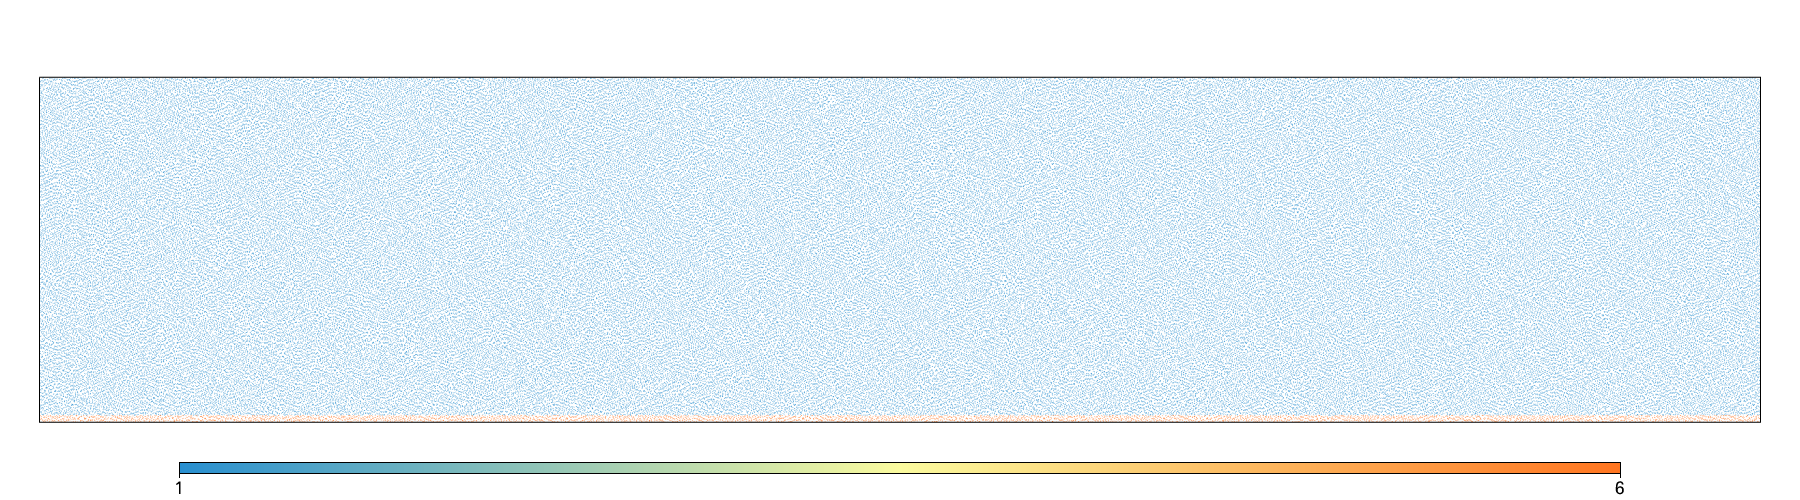

In [4]:
part_per_cell = 50
swarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout(
    swarm=swarm, particlesPerCell=part_per_cell)
swarm.populate_using_layout(layout=swarmLayout)

surfaceSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)
deformationSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)

# create pop control object
pop_control1 = uw.swarm.PopulationControl(swarm, aggressive=True, particlesPerCell=part_per_cell)
pop_control2 = uw.swarm.PopulationControl(surfaceSwarm)
pop_control3 = uw.swarm.PopulationControl(deformationSwarm)

# ### Create a particle advection system
#
# Note that we need to set up one advector system for each particle swarm (our global swarm and a separate one if we add passive tracers).
advector1 = uw.systems.SwarmAdvector(swarm=swarm,velocityField=velocityField, order=2)
advector2 = uw.systems.SwarmAdvector(swarm=surfaceSwarm,     velocityField=velocityField, order=2)
advector3 = uw.systems.SwarmAdvector(swarm=deformationSwarm, velocityField=velocityField, order=2)

# Tracking different materials

materialVariable = swarm.add_variable(dataType="int", count=1)

# passive markers at the surface are inserted whenever 100 m of new snow hav been created in the main loop
deformationPoints = np.array(np.meshgrid(np.linspace(0., maxX, int(
    number_of_deformation_points)), np.linspace(0., maxY, number_of_deformation_lines))).T.reshape(-1, 2)
deformationSwarm.add_particles_with_coordinates(deformationPoints)

surfacePoints = np.zeros((int(number_of_deformation_points), 2))
surfacePoints[:, 0] = np.linspace(0., maxX, int(number_of_deformation_points))
surfacePoints[:, 1] = maxY
surfaceSwarm.add_particles_with_coordinates(surfacePoints)

particleDensity = swarm.add_variable(dataType="double", count=1)
particleDensity.data[:] = 0.0

materialVariable.data[:] = materialV
materialVariable.data[botSet] = materialB

for index, coord in enumerate(swarm.particleCoordinates.data):
    if(coord[1] <= cell_height):  # inside the circle
        materialVariable.data[index] = materialB

#figMaterial = vis.Figure(figsize=(1800, 500))
#figMaterial.append(vis.objects.Points( swarm, materialVariable, pointSize=1.0))
#figMaterial.show()
#figMaterial.save_image("material.png")

# Functions

In [5]:
strainRateTensor = fn.tensor.symmetric(velocityField.fn_gradient)
strainRate_2ndInvariantFn = fn.tensor.second_invariant(strainRateTensor)

minViscosityIceFn = fn.misc.constant(1e+10 / 3.1536e7)
maxViscosityIceFn = fn.misc.constant(1e+15 / 3.1536e7)

viscosityFnAir = fn.misc.constant(1e6 / 3.1536e7)
viscosityFnRock = fn.misc.constant(1e22 / 3.1536e7)

viscosityFnIceBase = 0.5 * A ** (-1./n) * (strainRate_2ndInvariantFn**((1.-n) / n))
viscosityFnIce = fn.misc.max(fn.misc.min(viscosityFnIceBase, maxViscosityIceFn), minViscosityIceFn)

viscosityFnBase = cell_height * beta_square

viscosityMap = {
                materialV: viscosityFnIce,
                materialA: viscosityFnAir,
                materialR: viscosityFnRock,
                materialB: viscosityFnBase,
               }

viscosityFn = fn.branching.map( fn_key=materialVariable, mapping=viscosityMap )

logViscosityFn = fn.math.log10( fn.misc.max( fn.misc.min( viscosityFnIceBase, viscosityFnRock ), viscosityFnAir ) )

devStressFn = 2.0 * viscosityFn * strainRateTensor
shearStressFn = strainRate_2ndInvariantFn * viscosityFn * 2.0

densityFnAir = fn.misc.constant( 0. )
densityFnIce = fn.misc.constant( ice_density )
densityFnRock = fn.misc.constant( 2700. )

densityMap = {
                materialA: densityFnAir,
                materialV: densityFnIce,
                materialR: densityFnRock,
                materialB: densityFnIce,
             }

densityFn = fn.branching.map(fn_key=materialVariable, mapping=densityMap)

#particleDensity.data[:] = densityFn.evaluate(swarm)

particleDensity.data[:] = 910.

surf_inclination = 0.1 * np.pi / 180. # 0.1 = Experiment D, 0.5 = Experiment B
#surf_inclination = 0.
z_hat = (math.sin(surf_inclination), - math.cos(surf_inclination))

buoyancyFn = densityFn * z_hat * 9.81


# Solver and boundary conditions

In [1]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
base = mesh.specialSets["MinJ_VertexSet"]
top = mesh.specialSets["MaxJ_VertexSet"]

velocityField.data[:] = [0., 0.]

botSet = mesh.specialSets['Bottom_VertexSet']
topSet = mesh.specialSets['Top_VertexSet']
leftSet = mesh.specialSets['Left_VertexSet']
rightSet = mesh.specialSets['Right_VertexSet']

### Dirichlet
condition1 = uw.conditions.DirichletCondition(variable=velocityField,indexSetsPerDof=(botSet, botSet))

velocityField.data[:] = [0., 0.]
#velocityField.data[botSet] = basalVelocityField.data[botSet]

stokes = uw.systems.Stokes(
    velocityField=velocityField,
    pressureField=pressureField,
    voronoi_swarm=swarm,
    conditions=[
            condition1,
            ],
    fn_viscosity=viscosityFn,
    fn_bodyforce=buoyancyFn,
)

solver = uw.systems.Solver(stokes)

#solver.set_inner_method("lu")
#solver.set_inner_method("superlu")
#solver.set_inner_method("mumps")
#solver.set_inner_method("superludist")
solver.set_inner_method("mg")
#solver.set_inner_method("nomg")

# solver.set_penalty(1.0e10)  # higher penalty = larger stability
# solver.options.scr.ksp_rtol = 1.0e-3

# nl_tol = 2.e1
nl_tol = 5.e-3

surfaceArea = uw.utils.Integral( fn=1.0, mesh=mesh, integrationType='surface', surfaceIndexSet=top)
surfacePressureIntegral = uw.utils.Integral( fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=top)

def calibrate_pressure():

    global pressureField
    global surfaceArea
    global surfacePressureIntegral

    (area,) = surfaceArea.evaluate()
    (p0,) = surfacePressureIntegral.evaluate()
    pressureField.data[:] -= p0 / area

    print (f'Calibration pressure {p0 / area}')

# test it out
try:
    # nl_tol = 1e-2
    # nl_tol = 5.e-3
    # solver.solve(nonLinearIterate=True, nonLinearTolerance=nl_tol, callback_post_solve=calibrate_pressure)
    solver.solve(nonLinearIterate=True, callback_post_solve=calibrate_pressure)
    solver.print_stats()
except:
    print("Solver died early..")
    exit(0)

NameError: name 'mesh' is not defined

## Output

In [8]:
## correct the pressure
meshCorrectedPressure = mesh.add_variable( 1 )
meshSecondCorrectedPressure = mesh.add_variable( 1 )

## a) from the pressureField
meshCorrectedPress = uw.utils.MeshVariable_Projection( meshCorrectedPressure, pressureField, type=1 )
meshCorrectedPress.solve()

## b) from the stranirate tensor
pressureFn = (strainRateTensor[0] + strainRateTensor[1]) * viscosityFn
meshSecondCorrectedPress = uw.utils.MeshVariable_Projection( meshSecondCorrectedPressure, pressureFn, type=1 )
meshSecondCorrectedPress.solve()

## comment:
## note that the two integrals a) and b) above result in exactly the same pressure (as they should)

In [9]:
## correct the shear stress
devStressFn = 2.0 * viscosityFn * strainRateTensor

meshDevStress = mesh.add_variable( 1 )

projectorStress = uw.utils.MeshVariable_Projection( meshDevStress, fn.tensor.second_invariant(devStressFn), type=0 )
projectorStress.solve()

## maybe we can project the values twice ?
#projectorStress = uw.utils.MeshVariable_Projection( meshDevStress, meshDevStress, type=0 )
#projectorStress.solve()

In [16]:
# save to disc

outputFile = os.path.join(os.path.abspath("."), outputPath + "output_" + str(maxX) + ".csv")

with open(outputFile, "w") as text_file:

    text_file.write("X," + "Y," + "surf vx," + "surf vy," + "tau integr.," + "tau dir.," + "P integr.," + "P dir.," + "\n")
    
    for i, j in zip(iceRockInterfaceSet, iceAirInterfaceSet):
        
        textline = str(mesh.data[i][0]) +       "," \
            + str(mesh.data[i][1] ) +           "," \
            + str(velocityField.data[j][0]) +   "," \
            + str(velocityField.data[j][1]) +   "," \
            + str(meshDevStress.data[i][0]) +   "," \
            + str(shearStressFn.evaluate((mesh.data[i][0],mesh.data[i][1]))[0][0]) +   "," \
            + str(meshCorrectedPressure.data[i][0]) +   "," \
            + str(pressureFn.evaluate((mesh.data[i][0], mesh.data[i][1]))[0][0]) \
            + "\n"
        
        text_file.write(textline)

topo


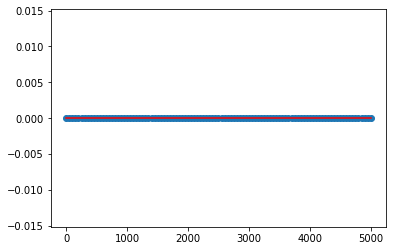

top x vel


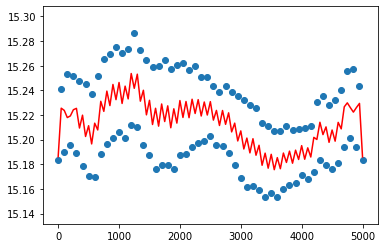

top y vel


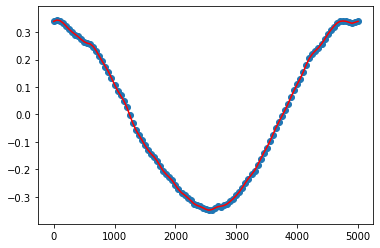

top total vel


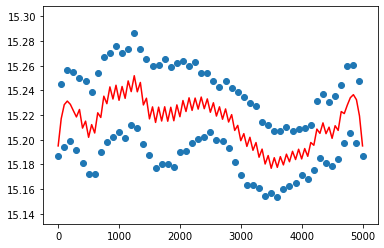

tau integr.


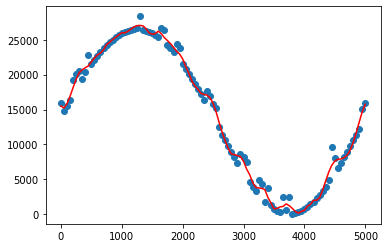

tau dir.


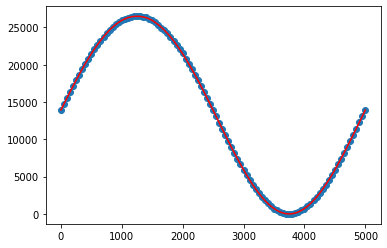

basal pressure integr.


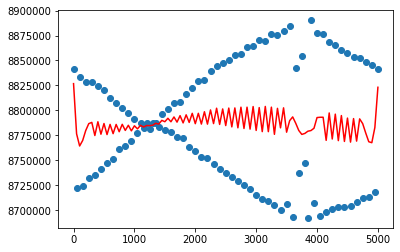

basal pressure dir.


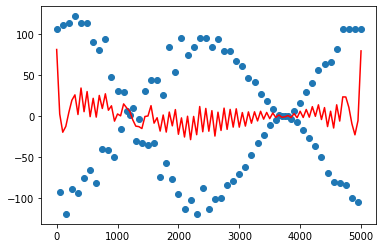

In [19]:
# plot saved files

outputFile = outputPath + "output_" + str(maxX) + ".csv"
a = np.loadtxt(open(outputFile, "rb"), delimiter=",", skiprows=1)
a = a.T

print ("topo")
pyplot.scatter (a[0], a[1])
yhat = savgol_filter(a[1], 13, 7)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()

print ("top x vel")
pyplot.scatter (a[0], a[2])
yhat = savgol_filter(a[2], 13, 7)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()

print ("top y vel")
pyplot.scatter (a[0], a[3])
yhat = savgol_filter(a[3], 13, 9)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()

print ("top total vel")
pyplot.scatter (a[0], np.sqrt(a[3]**2 + a[2]**2))
yhat = savgol_filter(np.sqrt(a[3]**2 + a[2]**2), 13, 5)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()

print ("tau integr.")
pyplot.scatter (a[0], a[4])
yhat = savgol_filter(a[4], 13, 4)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()

print ("tau dir.")
pyplot.scatter (a[0], a[5])
yhat = savgol_filter(a[5], 13, 5)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()

print ("basal pressure integr.")
pyplot.scatter (a[0], a[6])
yhat = savgol_filter(a[6], 13, 5)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()

print ("basal pressure dir.")
pyplot.scatter (a[0], a[7])
yhat = savgol_filter(a[7], 13, 5)
pyplot.plot(a[0], yhat, color='red')
pyplot.show()

In [ ]:
x = np.linspace(0, maxX, resX+1)

iceRockInterfaceSet = botSet

yhat = savgol_filter(velocityField.evaluate(mesh.data[iceAirInterfaceSet])[:,0], resX+1, 6)
pyplot.scatter(x, velocityField.evaluate(mesh.data[iceAirInterfaceSet])[:,0])
pyplot.plot(x, yhat, color='black')

yhat = savgol_filter(velocityField.evaluate(mesh.data[iceAirInterfaceSet])[:,1], resX+1, 6)
pyplot.scatter(x, velocityField.evaluate(mesh.data[iceAirInterfaceSet])[:,1])
pyplot.plot(x, yhat, color='black')

print ("Surface velocity vert (blue) and hor (red)")
pyplot.show()

####

yhat = savgol_filter(maxY - mesh.data[iceRockInterfaceSet,1], resX+1, 6)
pyplot.scatter(x, maxY - mesh.data[iceRockInterfaceSet,1], color='black')
pyplot.plot(x, yhat, color='black')

print ("Surface - Topo")
pyplot.show()

####

yhat = savgol_filter(velocityField.evaluate(mesh.data[iceRockInterfaceSet])[:,0], resX+1, 6)
pyplot.scatter(x, velocityField.evaluate(mesh.data[iceRockInterfaceSet])[:,0], color='red')
pyplot.plot(x, yhat, color='black')

#yhat = savgol_filter(velocityField.evaluate(mesh.data[iceRockInterfaceSet])[:,1], resX+1, 6)
#pyplot.scatter(x, velocityField.evaluate(mesh.data[iceRockInterfaceSet])[:,1], color='blue')
#pyplot.plot(x, yhat, color='black')

print ("Basal velocity vert (blue) and hor (red)")
pyplot.show()

####

yhat = savgol_filter(shearStressFn.evaluate(mesh.data[iceRockInterfaceSet])[:,0], resX+1, 4)
pyplot.plot(x, yhat, color='black')
pyplot.scatter(x, shearStressFn.evaluate(mesh.data[iceRockInterfaceSet])[:,0])

print ("Basal shear stress")
pyplot.show()

In [ ]:
# plot figures

figinflow = vis.Figure(figsize=(1800,500), title="free slip with in/out flow")
figinflow.append(vis.objects.VectorArrows(mesh, velocityField))
figinflow.append(vis.objects.Surface(mesh, uw.function.math.dot(velocityField,velocityField), colours="gebco"))
figinflow.save_image(outputPath + "velocity_" + str(maxX) + ".png")

figMaterial = vis.Figure(figsize=(1800, 500), title="Material")
figMaterial.append(vis.objects.Points( swarm, materialVariable, pointSize=1.0))
figMaterial.save_image(outputPath + "material_" + str(maxX) + ".png")

figDensity = vis.Figure(figsize=(1800, 500), title="Density")
figDensity.append(vis.objects.Points( swarm, particleDensity, pointSize=1.0))
figDensity.save_image(outputPath + "density_" + str(maxX) + ".png")

figViscosity = vis.Figure(figsize=(1800, 500), title="viscosity")
figViscosity.append(vis.objects.Surface(mesh, logViscosityFn))
figViscosity.save_image(outputPath + "logviscosity_" + str(maxX) + ".png")

figPressure = vis.Figure(figsize=(1800, 500), title="pressure")
figPressure.append(vis.objects.Surface(mesh, pressureField))
figPressure.save_image(outputPath + "pressure_" + str(maxX) + ".png")

In [ ]:
# finally save meshvars, swarmvars, xdmf vars
xdmf_info_mesh    = mesh.save('mesh.h5')
xdmf_info_meshVelocityField = velocityField.save('meshVelocityField.h5')
xdmf_info_meshDevStress = meshDevStress.save('meshDevStress.h5')
xdmf_info_meshCorrectedPressure = meshCorrectedPressure.save('meshCorrectedPressure.h5')

# swarm
xdmf_info_swarm    = swarm.save('swarm.h5')
xdmf_info_swarmMaterialVariable = materialVariable.save('swarmMaterialVariable.h5')

# xdmf mesh
velocityField.xdmf('meshVelocityField.xdmf', xdmf_info_meshVelocityField, "velocityField", xdmf_info_mesh, "TheMesh", modeltime=0.0)
meshDevStress.xdmf('meshDevStress.xdmf', xdmf_info_meshDevStress, "devStressField", xdmf_info_mesh, "TheMesh", modeltime=0.0)
meshCorrectedPressure.xdmf('meshCorrectedPressure.xdmf', xdmf_info_meshCorrectedPressure, "correctedPressureField", xdmf_info_mesh, "TheMesh", modeltime=0.0)

# xdmf swarm
materialVariable.xdmf('swarmMaterialVariable.xdmf', xdmf_info_swarmMaterialVariable, "material", xdmf_info_swarm, "TheSwarm", modeltime=0.0)